# Importer les librairies

In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob

from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

%matplotlib inline
tf.__version__


'2.12.0'

In [ ]:


import seaborn as sns
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

tf.random.set_seed(3)
from tensorflow import keras
from tensorflow.math import confusion_matrix


# Importer les donnees

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/dog',
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 401 files belonging to 2 classes.
Using 321 files for training.
Using 80 files for validation.


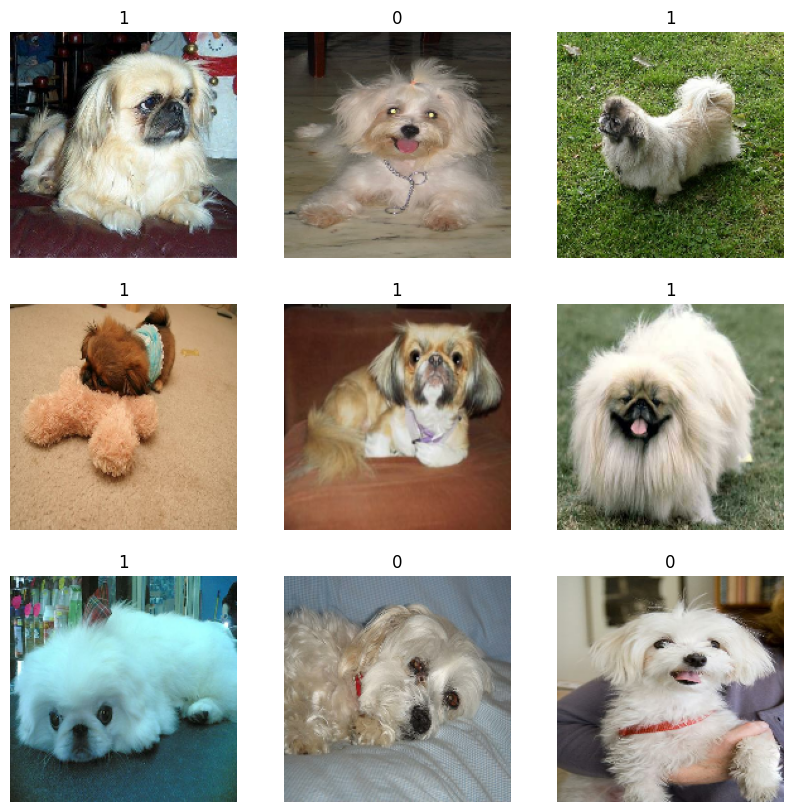

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

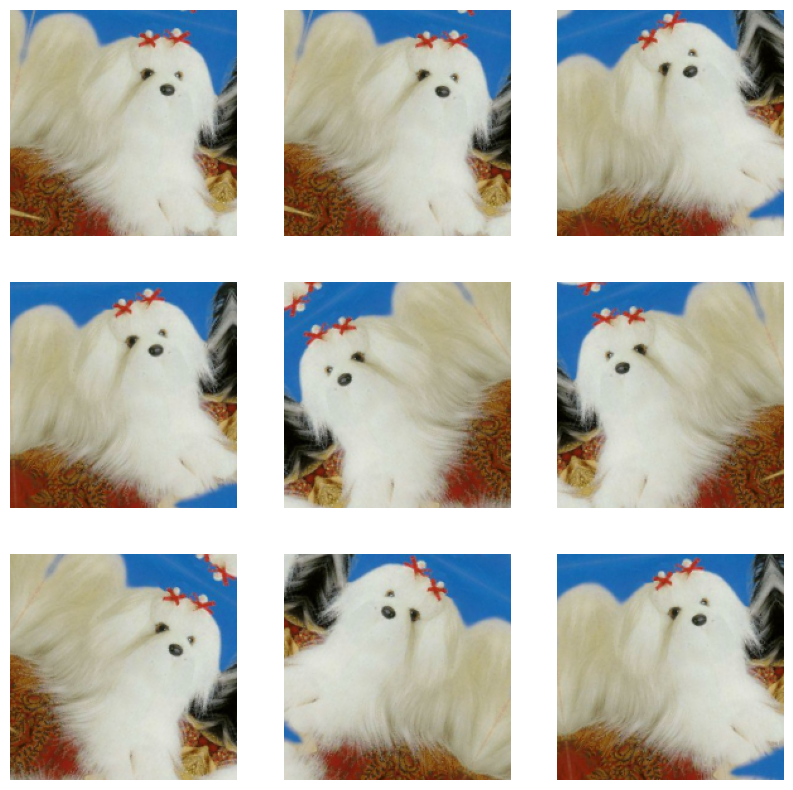

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Model 

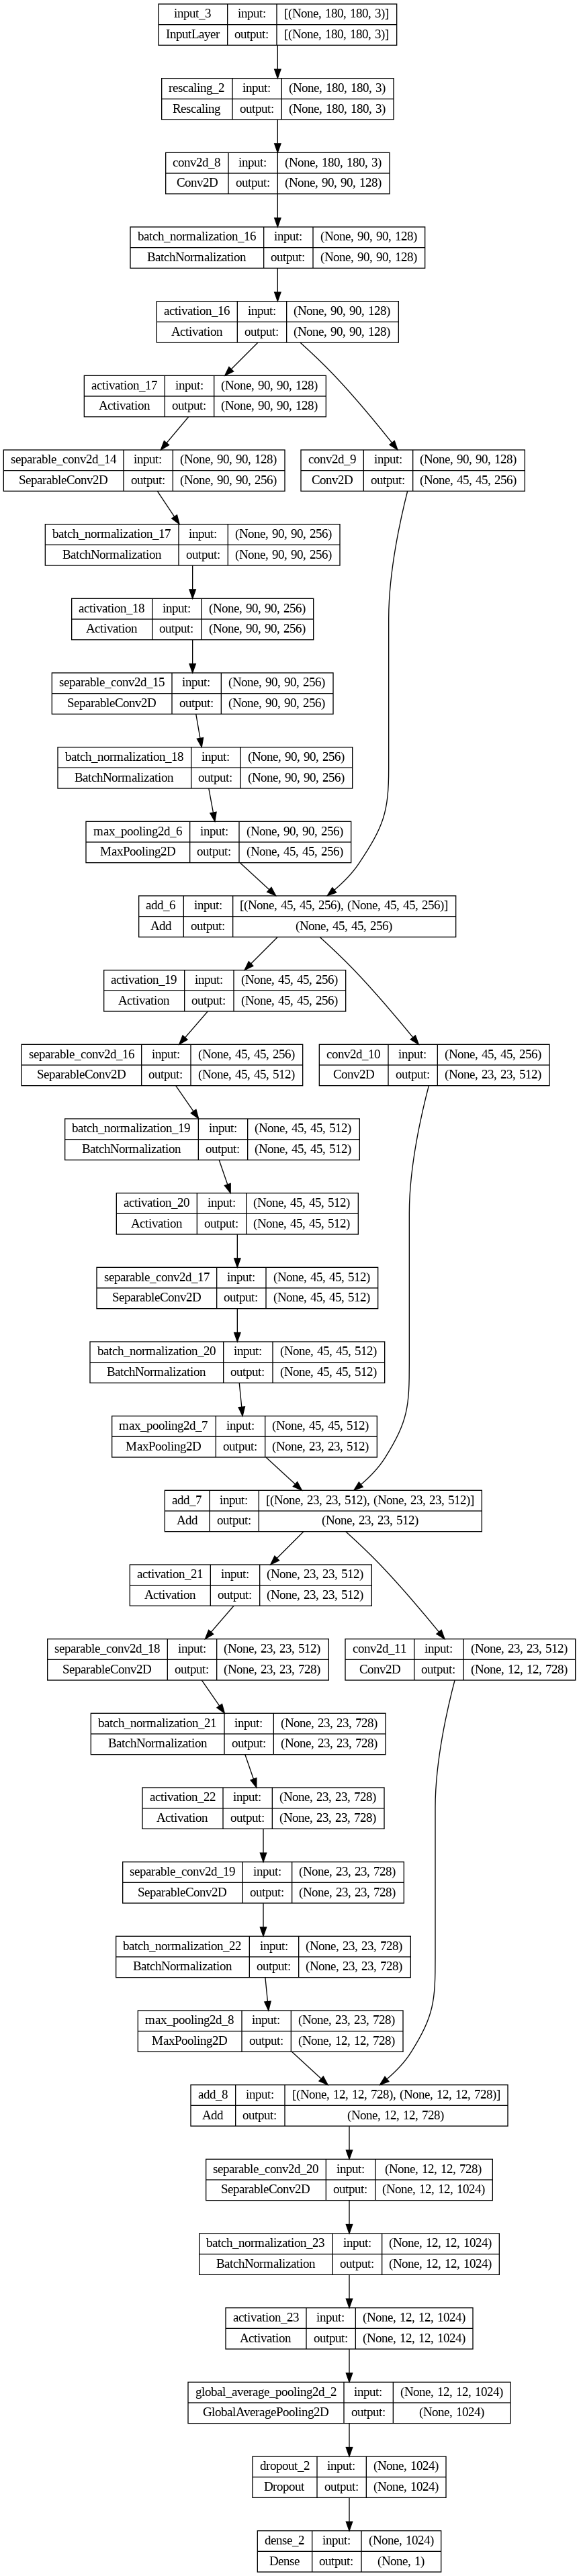

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

**Train the model**

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
3/3 [==============================] - 29s 9s/step - loss: 0.7438 - accuracy: 0.6262 - val_loss: 0.6924 - val_accuracy: 0.5250
Epoch 2/25
3/3 [==============================] - 5s 1s/step - loss: 0.6293 - accuracy: 0.6822 - val_loss: 0.6926 - val_accuracy: 0.5250
Epoch 3/25
3/3 [==============================] - 6s 2s/step - loss: 0.5730 - accuracy: 0.7072 - val_loss: 0.6926 - val_accuracy: 0.5250
Epoch 4/25
3/3 [==============================] - 6s 1s/step - loss: 0.5587 - accuracy: 0.7290 - val_loss: 0.6924 - val_accuracy: 0.5250
Epoch 5/25
3/3 [==============================] - 6s 2s/step - loss: 0.5409 - accuracy: 0.7508 - val_loss: 0.6922 - val_accuracy: 0.5250
Epoch 6/25
3/3 [==============================] - 5s 1s/step - loss: 0.5084 - accuracy: 0.7539 - val_loss: 0.6920 - val_accuracy: 0.5250
Epoch 7/25
3/3 [==============================] - 7s 1s/step - loss: 0.4509 - accuracy: 0.7632 - val_loss: 0.6920 - val_accuracy: 0.5250
Epoch 8/25
3/3 [========================

In [ ]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/dog/1000_F_137610025_2lnbq9td6tUCYqgDvpB8mZaJVzUeYrQQ.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
img_array = data_augmentation(img_array)

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% for pekinese and {100 * score:.2f}% maltese.")

1/1 [==============================] - 0s 21ms/step
This image is 52.49% for pekinese and 47.51% maltese.


# Annexe

In [ ]:
import matplotlib.image as mpimg

In [ ]:
img = mpimg.imread('/content/drive/MyDrive/n02085936-Maltese_dog/n02085936_10073.jpg')

In [ ]:
type(img)

numpy.ndarray

In [ ]:
print(img.shape)

(375, 500, 3)


In [ ]:
print(img)

[[[39 44 48]
  [38 43 47]
  [38 43 47]
  ...
  [18  8  7]
  [18  8  7]
  [18  8  7]]

 [[43 48 52]
  [43 48 52]
  [42 47 51]
  ...
  [17  7  6]
  [17  7  6]
  [17  7  6]]

 [[43 48 52]
  [43 48 52]
  [44 49 53]
  ...
  [19  9  8]
  [19  9  8]
  [19  9  8]]

 ...

 [[ 0 30  7]
  [ 0 32  9]
  [ 0 29  7]
  ...
  [55 60 64]
  [70 75 79]
  [82 87 91]]

 [[ 0 17  0]
  [ 0 24  2]
  [ 2 27  6]
  ...
  [36 41 45]
  [18 23 27]
  [ 1  6 10]]

 [[ 0 16  0]
  [ 0 21  0]
  [ 0 22  2]
  ...
  [62 67 71]
  [61 66 70]
  [59 64 68]]]


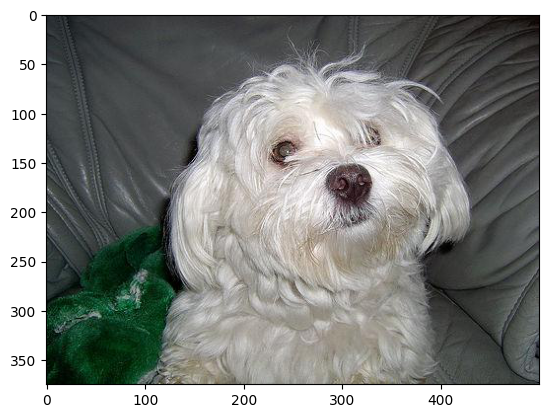

In [ ]:
# display image from array
img_plot = plt.imshow(img)

In [ ]:
# resize image
from PIL import Image

In [ ]:
img = Image.open('/content/drive/MyDrive/n02085936-Maltese_dog/n02085936_10073.jpg')
img_resized = img.resize((255,255))

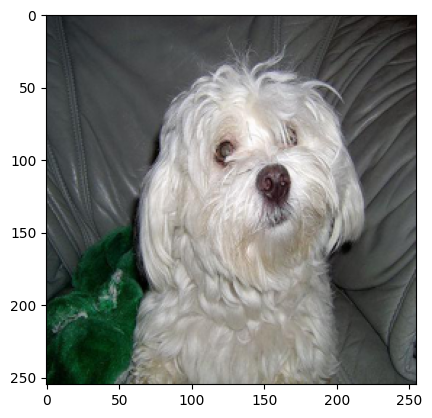

In [ ]:
plt.imshow(img_resized)

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Définir les chemins des dossiers contenant les images
data_dir = "/content/drive/MyDrive/n02085936-Maltese_dog"

# Définir les paramètres de prétraitement des images
batch_size = 32
img_height = 224
img_width = 224

# Créer un générateur d'images
data_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
data_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

# Afficher les classes d'images
print(data_generator.class_indices)


Found 0 images belonging to 0 classes.
{}


In [ ]:
import os
from PIL import Image
import pandas as pd

# Définir le chemin du dossier contenant les images
path = "/content/drive/MyDrive/n02085936-Maltese_dog"

# Parcourir le dossier et créer une liste avec les informations relatives aux images
image_data = []
for filename in os.listdir(path):
  with Image.open(os.path.join(path, filename)) as img:
    image_data.append([filename, img.format, img.size[0], img.size[1]])

# Créer un DataFrame avec les informations relatives aux images
df = pd.DataFrame(image_data, columns=["filename", "format", "width", "height"])

# Afficher le DataFrame
print(df)


                filename format  width  height
0    n02085936_10297.jpg   JPEG    375     500
1    n02085936_10273.jpg   JPEG    500     334
2    n02085936_10199.jpg   JPEG    500     375
3    n02085936_10073.jpg   JPEG    500     375
4    n02085936_10197.jpg   JPEG    500     375
..                   ...    ...    ...     ...
247   n02085936_9927.jpg   JPEG    399     298
248   n02085936_9632.jpg   JPEG    500     375
249   n02085936_9590.jpg   JPEG    500     375
250   n02085936_9812.jpg   JPEG    500     332
251   n02085936_9310.jpg   JPEG    500     375

[252 rows x 4 columns]


In [ ]:
df['filename'][0]

'n02085936_10297.jpg'

# Annexe : Preprecessing Images

Whitening 

Le blanchiment d'image (ou whitening en anglais) est une technique de prétraitement de l'image qui consiste à normaliser les valeurs de pixel de l'image en soustrayant la moyenne et en divisant par l'écart type de l'ensemble des pixels. Cette technique est souvent utilisée en traitement d'image et en apprentissage automatique pour améliorer la précision des modèles.

In [ ]:
import numpy as np
from PIL import Image

# Ouvrir l'image
image = Image.open("image.jpg")

# Convertir l'image en tableau NumPy
image_array = np.array(image)

# Calculer la moyenne et l'écart type de l'ensemble des pixels de l'image
mean = np.mean(image_array)
std = np.std(image_array)

# Soustraire la moyenne et diviser par l'écart type pour blanchir l'image
whitened_image_array = (image_array - mean) / std

# Convertir le tableau NumPy en image PIL
whitened_image = Image.fromarray(whitened_image_array.astype('uint8'))

# Enregistrer l'image blanchie
whitened_image.save("whitened_image.jpg")


# CNN

# Transfer Learning